In [1]:
import pathlib
import collections
from glob import glob

import numpy as np
from scipy import special

from astropy import nddata, visualization
visualization.quantity_support()
from astropy import units as u
from astropy.io import fits

from IPython.display import HTML
import ipywidgets

import specutils

import tqdm

first = lambda x:next(iter(x))

%matplotlib inline
from matplotlib import style, pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
cat_lines = [8498, 8542, 8662]*u.angstrom

In [3]:
datadir = pathlib.Path('/Users/erik/astrodata/DEIMOS/LeoT1')

In [4]:
ls $datadir

Allslits0.LeoT1.fits.gz
Allslits1.LeoT1.fits.gz
LeoT1.bintabs.fits
LeoT1.log
LeoT1.plan
LeoT1_1d.log
LeoT1_mcerr.log
arcwave_qa1.fits
arcwave_qa2.fits
arcwave_qa3.fits
arcwave_qa4.fits
arcwave_qa5.fits
arcwave_qa6.fits
arcwave_qa7.fits
arcwave_qa8.fits
calibSlit.LeoT1.000B.fits.gz
calibSlit.LeoT1.000R.fits.gz
calibSlit.LeoT1.001B.fits.gz
calibSlit.LeoT1.001R.fits.gz
calibSlit.LeoT1.002B.fits.gz
calibSlit.LeoT1.002R.fits.gz
calibSlit.LeoT1.003B.fits.gz
calibSlit.LeoT1.003R.fits.gz
calibSlit.LeoT1.004B.fits.gz
calibSlit.LeoT1.004R.fits.gz
calibSlit.LeoT1.005B.fits.gz
calibSlit.LeoT1.005R.fits.gz
calibSlit.LeoT1.006B.fits.gz
calibSlit.LeoT1.006R.fits.gz
calibSlit.LeoT1.007B.fits.gz
calibSlit.LeoT1.007R.fits.gz
calibSlit.LeoT1.008B.fits.gz
calibSlit.LeoT1.008R.fits.gz
calibSlit.LeoT1.009B.fits.gz
calibSlit.LeoT1.009R.fits.gz
calibSlit.LeoT1.010B.fits.gz
calibSlit.LeoT1.010R.fits.gz
calibSlit.LeoT1.011B.fits.gz
calibSlit.LeoT1.011R.fits.gz
calibSlit.LeoT1.012B.fits.gz
calibSlit.LeoT1.012R.f

In [5]:
zspecs = {}
for fn in tqdm.tqdm_notebook(glob(str(datadir / 'zspec1d.LeoT1.*.fits.gz'))):
    nm = fn.split('LeoT1.')[-1].replace('.fits.gz', '')
    d = fits.getdata(fn, 1)
    zspecs[nm] = specutils.Spectrum1D(spectral_axis=d[0]['LAMBDA']*u.angstrom, flux=d[0]['SPEC']*u.count,
                                      uncertainty=nddata.InverseVariance(d[0]['IVAR']))
    for dnm in d.dtype.names:
        if dnm not in ('SPEC', 'LAMBDA', 'IVAR'):
            zspecs[nm].meta[dnm] = d[dnm][0]

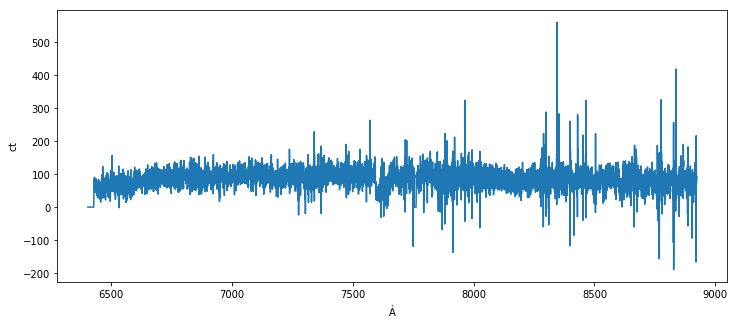

In [6]:
fig = plt.figure(figsize=(12, 5))
fspec = first(zspecs.values())
plt.plot(fspec.wavelength, fspec.flux)

/Users/erik/miniconda3/envs/astro36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


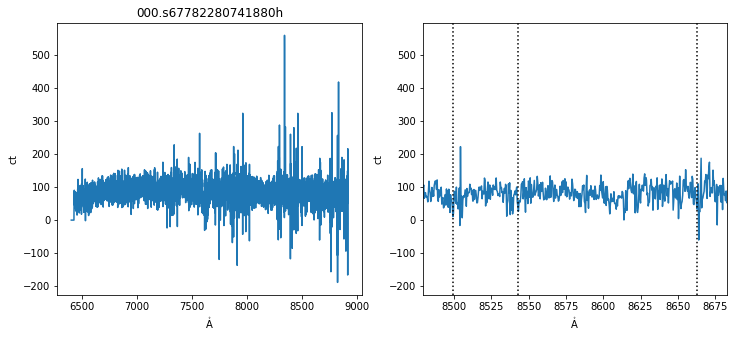

In [7]:
zline = 35./3e5 + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

def animate(key):
    spec = zspecs[key]
    for ax in [ax1, ax2]:
        ax.cla()
        ax.plot(spec.wavelength, spec.flux)
    ax1.set_title(key)
    ax2.set_xlim(cat_lines[0]*zline-20*u.angstrom, cat_lines[-1]*zline+20*u.angstrom)
    for line in cat_lines:
        ax2.axvline(line*zline, c='k', ls=':')

ani = FuncAnimation(fig, animate, frames=zspecs.keys())
HTML(ani.to_jshtml())

# Proper widget 

In [8]:
zspec_vals = collections.defaultdict(lambda:0)
spec_comments = collections.defaultdict(lambda:'')

In [9]:
zline = 35./3e5 + 1

def f(specname):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    spec = zspecs[specname]
    for ax in [ax1, ax2]:
        ax.cla()
        ax.plot(spec.wavelength, spec.flux)
    ax1.set_title(specname)
    ax2.set_xlim(cat_lines[0]*zline-20*u.angstrom, cat_lines[-1]*zline+20*u.angstrom)
    for line in cat_lines:
        ax2.axvline(line*zline, c='k', ls=':')
    
    plt.show()

dropdown = ipywidgets.Dropdown(options=zspecs.keys())
left = ipywidgets.Button(description='<')
right = ipywidgets.Button(description='>')

def on_left_clicked(b):
    idx = dropdown.options.index(dropdown.value)
    if idx > 0:
        dropdown.value = dropdown.options[idx-1]
left.on_click(on_left_clicked)
def on_right_clicked(b):
    idx = dropdown.options.index(dropdown.value)
    if idx < len(dropdown.options)-1:
        dropdown.value = dropdown.options[idx+1]
right.on_click(on_right_clicked)

zspec = ipywidgets.Dropdown(options=[-1,0,1,2,3,4], description='zspec:')
comments = ipywidgets.Text(description='Comments:')

apply = ipywidgets.Button(description='apply')
def on_apply_clicked(b):
    zspecs[dropdown.value] = zspec_vals.value
    spec_comments[dropdown.value] = comments.value
apply.on_click(on_apply_clicked)
    
top = ipywidgets.HBox([left, dropdown, right])
lower = ipywidgets.HBox([zspec, comments, apply])
ui = ipywidgets.VBox([top, lower])
out = ipywidgets.interactive_output(f, dict(specname=dropdown))

display(ui, out)

Output()

In [10]:
zspec_vals

defaultdict(<function __main__.<lambda>()>, {})

### Combined slits 

In [11]:
def get_slit_by_num(num, ext=1, sp=False):
    spors = 'spS' if sp else 's'
    slrf = fits.open(datadir / (spors + f'lit.LeoT1.{num:03}R.fits.gz'))
    slbf = fits.open(datadir / (spors + f'lit.LeoT1.{num:03}B.fits.gz'))
    if ext is None:
        return slbf, slrf
    elif ext == 'sp':
        sprs = [hdu for hdu in slrf if hdu.name == 'spSlit']
        spbs = [hdu for hdu in slbf if hdu.name == 'spSlit']
        return spbs, sprs
    else:
        return slbf[ext].data, slrf[ext].data

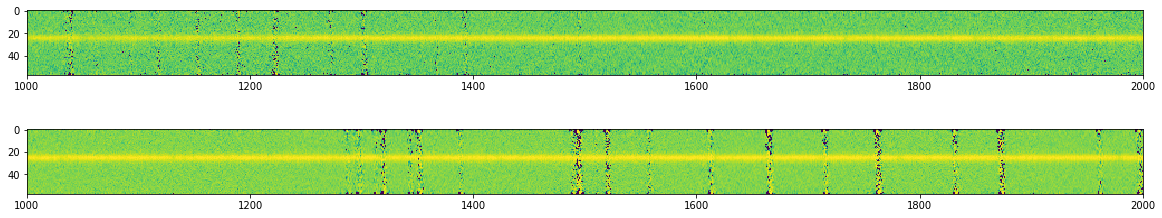

In [12]:
slb, slr = get_slit_by_num(1)
flxr = slr[0]['FLUX']
wlr = (slr[0]['LAMBDA0'] + slr[0]['DLAMBDA'])*u.angstrom
flxb = slb[0]['FLUX']
wlb = (slb[0]['LAMBDA0'] + slb[0]['DLAMBDA'])*u.angstrom

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 4))
visualization.imshow_norm(flxb, ax=ax1,
                          stretch=visualization.LogStretch(), interval=visualization.PercentileInterval(98))
visualization.imshow_norm(flxr, ax=ax2,
                          stretch=visualization.LogStretch(), interval=visualization.PercentileInterval(98))
for ax in (ax1, ax2):
    ax.set_xlim(1000, 2000)

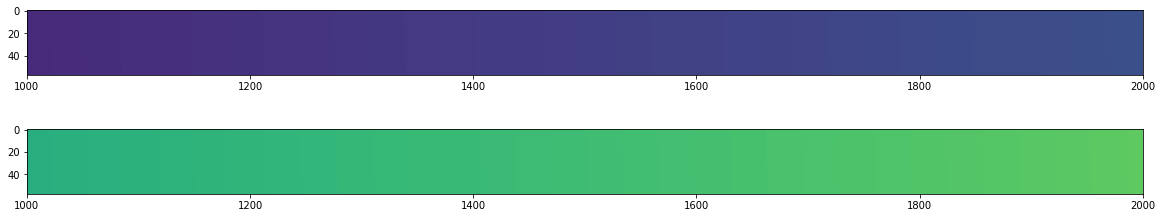

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 4))

ax1.imshow(wlb.value, vmin=np.min(wlb).value, vmax=np.max(wlr).value)
ax2.imshow(wlr.value, vmin=np.min(wlb).value, vmax=np.max(wlr).value)
for ax in (ax1, ax2):
    ax.set_xlim(1000, 2000)

(0, 60)

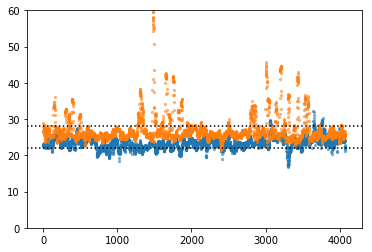

In [14]:
smooth = 20

flx = slr[0]['FLUX']
wl = (slr[0]['LAMBDA0'] + slr[0]['DLAMBDA'])*u.angstrom
cents = []
for rowi in range(flx.shape[1]-(smooth-1)):
    row = np.sum(flx[:, rowi:rowi+smooth], axis=1)
    x = np.arange(len(row))
    cents.append(np.sum(x*row)/np.sum(row))
centsr = np.array(cents)

flx = slb[0]['FLUX']
wl = (slb[0]['LAMBDA0'] + slb[0]['DLAMBDA'])*u.angstrom
cents = []
for rowi in range(flx.shape[1]-(smooth-1)):
    row = np.sum(flx[:, rowi:rowi+smooth], axis=1)
    x = np.arange(len(row))
    cents.append(np.sum(x*row)/np.sum(row))
centsb = np.array(cents)

plt.scatter(np.arange(centsb.shape[0]), centsb, alpha=.5, s=5)
plt.scatter(np.arange(centsr.shape[0]), centsr, alpha=.5, s=5)
plt.axhline(zspecs['001.s67735028630104h'].meta['R1'], c='k', ls=':')
plt.axhline(zspecs['001.s67735028630104h'].meta['R2'], c='k', ls=':')
plt.ylim(0, 60)

### Individual exposures 

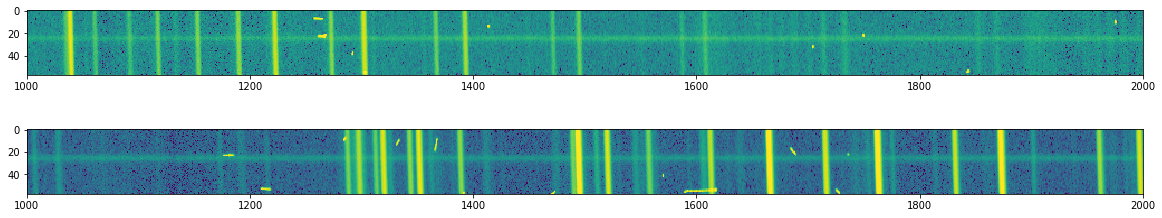

In [15]:
slb, slr = get_slit_by_num(1, ext=1, sp=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 4))
visualization.imshow_norm(slb[0]['FLUX'], ax=ax1,
                          stretch=visualization.LogStretch(), interval=visualization.PercentileInterval(98))
visualization.imshow_norm(slr[0]['FLUX'], ax=ax2,
                          stretch=visualization.LogStretch(), interval=visualization.PercentileInterval(98))
for ax in (ax1, ax2):
    ax.set_xlim(1000, 2000)

In [16]:
spbs, sprs = get_slit_by_num(1, 'sp', sp=True)

In [17]:
spbs[0].data['SKYROW']

array([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=uint8)

Aha!  There's a way to get "these are sky pixels"

In [18]:
# lambda_eval.pro equivalent
def lambda_eval(calib_slit_data):
    x = np.linspace(-1, 1, spbs[0].data['FLUX'].shape[-1])
    px = np.polynomial.legendre.legval(x, calib_slit_data['LAMBDAX'][0])
    fx = np.polynomial.legendre.legval(x, calib_slit_data['TILTX'][0])
    
    dl = np.clip(calib_slit_data['DLAM'][0].copy(), -10, 10)
    
    nrow = calib_slit_data['FLUX'].shape[1]
    wv = px*(1+ (np.arange(nrow)[:, np.newaxis] - nrow/2)*fx) + dl[:, np.newaxis]
    
    return wv*u.angstrom
lambda_eval(spbs[0].data)

<Quantity [[6529.92201431, 6530.24214536, 6530.56227978, ...,
            7856.51030028, 7856.83472532, 7857.15914843],
           [6529.90886643, 6530.22899749, 6530.54913189, ...,
            7856.49577287, 7856.82019722, 7857.14461964],
           [6529.90534255, 6530.2254736 , 6530.545608  , ...,
            7856.49086945, 7856.81529312, 7857.13971485],
           ...,
           [6529.54002078, 6529.86015155, 6530.18028562, ...,
            7856.05243221, 7856.37681947, 7856.70120474],
           [6529.5190504 , 6529.83918116, 6530.15931523, ...,
            7856.03008229, 7856.35446886, 7856.67885345],
           [6529.48755995, 6529.8076907 , 6530.12782477, ...,
            7855.9972123 , 7856.32159819, 7856.64598208]] Angstrom>

#### Do a test for just the one slit

/Users/erik/miniconda3/envs/astro36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in power
  del sys.path[0]


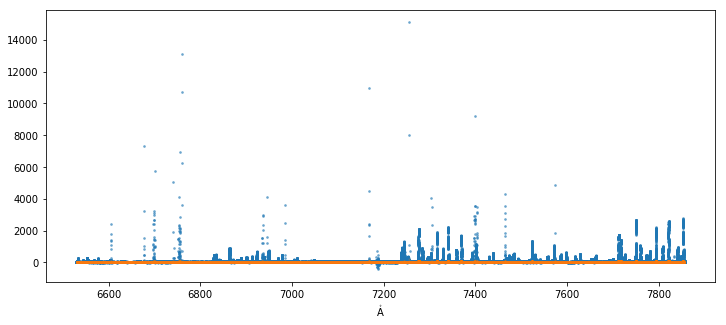

In [19]:
def get_sky(dat):
    skymsk = dat['SKYROW'][0]==1
    lamb = lambda_eval(dat)
    skylamb = lamb[skymsk]
    skyflux = dat['FLUX'][0,skymsk]
    skyivar = dat['IVAR'][0,skymsk]
    return skylamb, skyflux, skyivar

skylamb, skyflux, skyivar = get_sky(spbs[0].data)

plt.figure(figsize=(12, 5))
plt.scatter(skylamb, skyflux, s=3, alpha=.5)
plt.scatter(skylamb, skyivar**-0.5, s=2, alpha=.15)

#### Try the whole mask

In [42]:
skylambs = []
skyfluxs = []
skyivars = []
isbs = []
mjds = []

for i in tqdm.tqdm_notebook(range(118)):
    try:
        spbs, sprs = get_slit_by_num(i, 'sp', sp=True)
    except FileNotFoundError:
        print(i, 'was not found ...')
    for isb, spxs in zip((True, False), (spbs, sprs)):
        for sp in spxs:
            skylamb, skyflux, skyivar = get_sky(sp.data)
            skylambs.append(skylamb)
            skyfluxs.append(skyflux)
            skyivars.append(skyivar)
            isbs.append(isb*np.ones(skyivar.shape, dtype=bool))
            mjds.append(float(sp.header['MJD-OBS'])*np.ones(skyivar.shape, dtype=bool))
            
all_skylamb = np.concatenate([sl.ravel().value for sl in skylambs])*skylambs[0].unit
all_skyflux = np.concatenate([s.ravel() for s in skyfluxs])
all_skyivar = np.concatenate([s.ravel() for s in skyivars])
all_isbs = np.concatenate([s.ravel() for s in isbs])
all_mjds = np.concatenate([s.ravel() for s in mjds])
all_skylamb.shape

21 was not found ...
38 was not found ...
94 was not found ...



(152027136,)

Note - the above is ~ GB of RAM, so don't have a ton of memory headroom left